# Project module usage

For this article's analysis, we wanted to develop a minimal Python module that would yet deliver a sufficient amount of flexibility so we could easily compare solutions to the randomized trial setting formulated as a Multi-Armed Bandit Problem.

## Introduction to the code structure

All the Python module is located in the `project/` folder. From the repository's root (this notebook's location), one can import this module from Python, using one of the statements below.

```python
import project
from project import <submodule>
```

The components (or submodules) of `project` are the following:

- `bandit`  
    Definitions of the `Arm` baseclass and a `BernouilliArm` implementation.  
    Definition of the `Bandit` problem "shell", to manipulate a set of arms.


- `oracle`  
    Definition of the `Oracle` object, the tool used to evaluate policies on a given `Bandit`.


- `policy`  
    Definitions of the `Policy` baseclass and a few other implementations.


- `utils`  
    Some generic Python utilities for tasks such as execution timing and random state management.

## Usage example : `Oracle`

To show a really basic usage of the module, we demonstrate how to use the Oracle to evaluate a set of random (uniform pick between arms at each step) policies on a simple 5-armed bandit.

- First, let's generate a set of policies:

In [1]:
from project.policy import RandomPolicy

n_policies = 3

policies = [
    RandomPolicy() for _ in range(n_policies)
]

- Then, let's construct our `Oracle` for this set of policies

In [2]:
from project.oracle import Oracle

oracle = Oracle(policies=policies)

- To use the `Oracle`, we need to construct a `Bandit` against which we'll evaluate the policies performance. The method `oracle.set_bandit` is used to bind the `Bandit` instance to the oracle.

In [3]:
from project.bandit import Bandit, BernouilliArm

bandit = Bandit.generate(
    arm_class=BernouilliArm,
    arm_kwargs=(
        {'p': 0.1},
        {'p': 0.4},
        {'p': 0.6},
        {'p': 0.8},
        {'p': 0.9},
    )
)

oracle.set_bandit(bandit=bandit)

- Now, we can simply `evaluate` the policies and store the `Oracle.Report` object:

In [4]:
n_runs = 400
report = oracle.evaluate(
    n_runs=n_runs
)

- We can use the report and the oracle to display results of the evaluations:

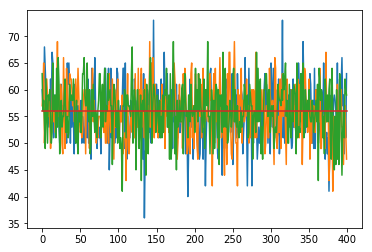

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

for i in range(n_policies):
    plt.plot(np.sum(report.results[:,i,:], axis=1))

# Using the bandit object, we compute its mean expected reward across all
# arms.
avg_reward = np.mean([arm.p for arm in bandit.arms])
plt.plot(avg_reward * 100 * np.ones(n_runs))

_Note: there's still a need to show how to use _`n_steps`_ in _`evaluate`_._

## Usage example: policy implementation

To demonstrate how to implement a new policy using this framework, we'll attempt to implement the _Upper Confidence Bound_ (UCB) algorithm.

Here's the source for the `Policy` abstract base class:

```python

class Policy(RandomStateMixin, metaclass=abc.ABCMeta):
    """Policy base-class for interacting with the Bandit environment."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def run(
        self, bandit: bandit.Bandit, n_steps: int, **kwargs
    ) -> Tuple[int, float]:
        self.prepare(n_arms=bandit.n_arms, n_steps=n_steps)

        action, reward = np.zeros(n_steps), np.zeros(n_steps)

        for step in range(n_steps):
            arm = self.pick()
            action[step] = arm
            reward[step] = bandit.draw(arm)
            self.receive(arm, reward[step])

        return action, reward

    @abc.abstractmethod
    def prepare(self, **kwargs):
        """Initialize internal state variables for a full run."""
        pass

    @abc.abstractmethod
    def pick(self) -> int:
        """Choose an arm according to previously observed results."""
        pass

    @abc.abstractmethod
    def receive(self, arm: int, reward: 'Union[int, float]'):
        """Update internal state variables according to received reward."""
        pass

```

In [6]:
from project.policy import Policy

In [24]:
class UCBPolicy(Policy):
    """Implementation of the Upper Confidence Bound algorithm."""
    def __init__(
        self,
        delta: float,
        arm_prior: 'Tuple[int, int]'=(1, 1),
        **kwargs
    ):
        super().__init__(**kwargs)
        self.delta = delta
        self.arm_prior = arm_prior

    def prepare(self, n_arms: int, **kwargs):
        self._counts = [0] * n_arms
        self._states = [self.arm_prior] * n_arms
    
    def pick(self):
        best_arm = np.argmax(self._get_arm_values())
        
        self._counts[best_arm] += 1
        return best_arm
    
    def receive(self, arm, reward):
        last_state = self._states[arm]
        
        if reward == 1:
            self._states[arm] = (last_state[0] + 1, last_state[1])
        else:
            self._states[arm] = (last_state[0], last_state[1] + 1)
    
    def _get_arm_values(self):
        """Return the array of values attributed to each arm.
        
        If any of the arms was not picked yet, the values will be 1 for any
        unpicked arm and 0 for the others.
        When all arms were once drawn, an arm value has the shape:
        
            s / (s + f)  +  delta * sqrt( log(T) / T(i) )
        
        where T(i) is the number of times the arm i was picked until now.
        """
        if any(c == 0 for c in self._counts):
            # Test all arms first
            return np.array([
                1 if c == 0 else 0
                for c in self._counts
            ])
        
        return np.array([
            self.get_prob(state) + self.get_confidence_bound(arm)
            for arm, state in enumerate(self._states)
        ])
    
    @staticmethod
    def get_prob(state):
        """success / (success + failure)"""
        if not all(state):
            raise ValueError(state)
        
        return state[0] / sum(state)
    
    def get_confidence_bound(self, arm):
        """delta * sqrt( log(T) / T(i) )"""
        return self.delta * np.sqrt(
            np.log(np.sum(self._counts)) / (self._counts[arm])
        )

In [25]:
policies = [
    RandomPolicy(),
    UCBPolicy(delta=2)
]

In [26]:
oracle = Oracle(policies=policies)
oracle.set_bandit(bandit)

In [36]:
n_runs = 500
n_steps = 1000

report = oracle.evaluate(
    n_runs=n_runs,
    run_length=n_steps
)

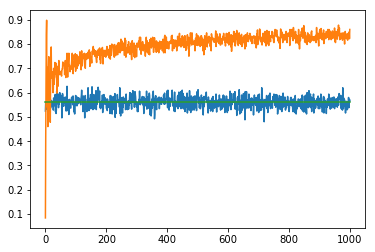

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

for i in range(2):
    plt.plot(np.mean(report.results[:,i,:], axis=0))

# Using the bandit object, we compute its mean expected reward across all
# arms.
avg_reward = np.mean([arm.p for arm in bandit.arms])
plt.plot(avg_reward * np.ones(n_steps))